<a href="https://colab.research.google.com/github/llayer/StromboliWF/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = pd.read_hdf('/content/gdrive/My Drive/signal_norm.h5')

In [0]:
def exclude_days(df, days):
    
    for day in days:
        mask = ((df['time'] < day[0]) | (df['time'] > day[1]))
        df = df.loc[mask]
    return df

In [0]:
# Exclude the eruption days
eruption_days = [ ('2019-07-03', '2019-07-04'), ('2019-08-28', '2019-08-29'), ('2019-08-29', '2019-08-30')]
df = exclude_days(df, eruption_days)

In [17]:
len(df)

19748

In [0]:
df = df.dropna()

In [19]:
len(df)

19748

In [0]:
features = df.drop(['time'], axis=1)

In [0]:
features = features.values

In [22]:
features.shape

(19748, 1550)

In [23]:
np.isnan(features).any()

False

## 1. Dense auto encoder

In [0]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.optimizers import Adam, SGD
from keras.utils import plot_model


In [0]:
def train_dense(features, encoding_dim):

    input_img= Input(shape=(features.shape[1],))
    encoded = Dense(units=500, activation='relu')(input_img)
    #encoded = Dense(units=200, activation='relu')(encoded)
    encoded = Dense(units=encoding_dim, activation='relu')(encoded)
    decoded = Dense(units=500, activation='relu')(encoded)
    #decoded = Dense(units=500, activation='relu')(decoded)
    decoded = Dense(units=features.shape[1])(decoded)

    # Building autoencoder
    autoencoder=Model(input_img, decoded)
    #extracting encoder
    encoder = Model(input_img, encoded)
    # compiling the autoencoder
    ADAM = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=100)
    autoencoder.compile(optimizer=ADAM, loss='mean_squared_error', metrics=['accuracy'])
    
    #plot_model(autoencoder, show_shapes=True, show_layer_names=False)
    
    history = autoencoder.fit(features, features, epochs=100, batch_size = 32, validation_split=0.2, verbose=1)  

    return history, autoencoder, encoder

In [137]:
#history, autoencoder, encoder = train_dense(features, 100)
history_200, autoencoder_200, encoder_200 = train_dense(features, 200)
#history_300, autoencoder_300, encoder_300 = train_dense(features, 300)


Train on 15798 samples, validate on 3950 samples
Epoch 1/100
15798/15798 [==============================] - 4s 254us/step - loss: 0.8472 - acc: 0.0234 - val_loss: 0.7548 - val_acc: 0.0420
Epoch 2/100
15798/15798 [==============================] - 3s 202us/step - loss: 0.6092 - acc: 0.0818 - val_loss: 0.6137 - val_acc: 0.0846
Epoch 3/100
15798/15798 [==============================] - 3s 205us/step - loss: 0.5093 - acc: 0.1248 - val_loss: 0.5503 - val_acc: 0.1154
Epoch 4/100
15798/15798 [==============================] - 3s 207us/step - loss: 0.4584 - acc: 0.1582 - val_loss: 0.5094 - val_acc: 0.1365
Epoch 5/100
15798/15798 [==============================] - 3s 206us/step - loss: 0.4254 - acc: 0.1819 - val_loss: 0.4824 - val_acc: 0.1542
Epoch 6/100
15798/15798 [==============================] - 3s 201us/step - loss: 0.4020 - acc: 0.2048 - val_loss: 0.4618 - val_acc: 0.1656
Epoch 7/100
15798/15798 [==============================] - 3s 199us/step - loss: 0.3844 - acc: 0.2210 - val_loss: 0.4

In [0]:
def predict(encoder, autoencoder, name = 'dense', store=True):

    preds_encode = encoder.predict(features)
    preds_auto = autoencoder.predict(features)

    if store == True:
        dim = preds_encode.shape[1]
        preds_df = pd.DataFrame(preds_encode)
        preds_df['time'] = df['time']
        print(preds_df.shape)
        print(name +'_' + str(dim) + '.h5')
        preds_df.to_hdf('/content/gdrive/My Drive/' + name +'_' + str(dim) + '.h5', 'frame', store= 'tables')
    
    return preds_encode, preds_auto

In [150]:
preds_encode, preds_auto = predict(encoder_300, autoencoder_300)

(19748, 301)
dense_300.h5


/usr/local/lib/python3.6/dist-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['time']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


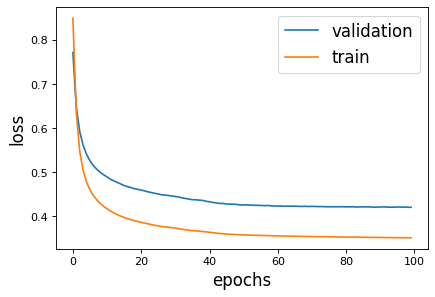

In [125]:
plt.figure(figsize=(6,4), dpi=80)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.ylabel('loss', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(['validation', 'train'], loc='upper right', prop={'size': 15})

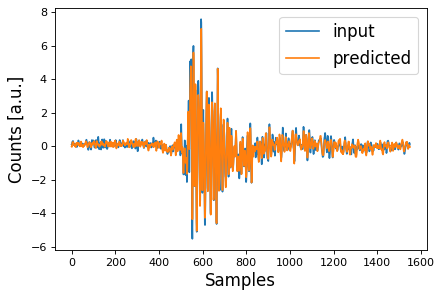

In [148]:
import matplotlib.pyplot as plt
ifeat = 4

plt.figure(figsize=(6,4), dpi=80)
plt.plot(features[ifeat], alpha = 1)
plt.plot(preds_auto[ifeat], alpha=1)
plt.ylabel('Counts [a.u.]', fontsize=15)
plt.xlabel('Samples', fontsize=15)
plt.legend(['input', 'predicted'], loc='upper right', prop={'size': 15})

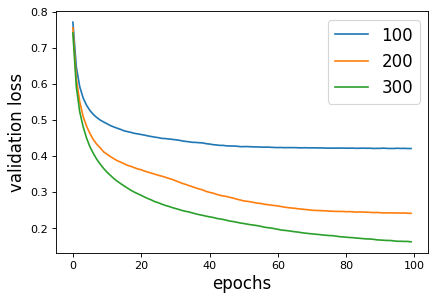

In [143]:
plt.figure(figsize=(6,4), dpi=80)
plt.plot(history.history['val_loss'])
plt.plot(history_200.history['val_loss'])
plt.plot(history_300.history['val_loss'])
plt.ylabel('validation loss', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(['100', '200', '300'], loc='upper right', prop={'size': 15})

## 2. LSTM autoencoder

In [0]:
features = features.reshape((features.shape[0], 31, 50))
features = features.reshape(features.shape[0] * 31, features.shape[2], 1)

In [206]:
features.shape

(612188, 50, 1)

In [0]:
def train_lstm(features, encoding_dim):

    # 16 worked with tanh and the defined ADAM
    # define model
    model = Sequential()
    #model.add(LSTM(10, activation='tanh', input_shape=(features.shape[1],1)))
    model.add(CuDNNLSTM(encoding_dim, input_shape=(features.shape[1],1)))
    model.add(RepeatVector(features.shape[1]))
    #model.add(LSTM(10, activation='tanh', return_sequences=True))
    model.add(CuDNNLSTM(encoding_dim, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    sgd = SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True,clipnorm=100)
    ADAM = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=100)
    model.compile(optimizer=ADAM, loss='mse' )#binary_crossentropy') # loss='mse')
    
    #plot_model(model, show_shapes=True, show_layer_names=False)

    #history = model.fit(features, features, epochs=20, batch_size = 32, validation_split=0.2, verbose=1)  
    history = model.fit(features, features, epochs=20, batch_size = 32, validation_split=0.2, verbose=1)  

    lstm_encoder = Model(inputs=model.inputs, outputs=model.layers[0].output)

    return history, model, lstm_encoder

In [175]:
history, auto_10, encoder_10 = train_lstm(features, 10)

Train on 489750 samples, validate on 122438 samples
Epoch 1/20
489750/489750 [==============================] - 148s 303us/step - loss: 0.4888 - val_loss: 0.3662
Epoch 2/20
489750/489750 [==============================] - 145s 297us/step - loss: 0.3417 - val_loss: 0.3130
Epoch 3/20
489750/489750 [==============================] - 146s 299us/step - loss: 0.2928 - val_loss: 0.2707
Epoch 4/20
489750/489750 [==============================] - 146s 298us/step - loss: 0.2669 - val_loss: 0.2441
Epoch 5/20
489750/489750 [==============================] - 145s 295us/step - loss: 0.2491 - val_loss: 0.2250
Epoch 6/20
489750/489750 [==============================] - 145s 297us/step - loss: 0.2309 - val_loss: 0.2177
Epoch 7/20
489750/489750 [==============================] - 146s 299us/step - loss: 0.2209 - val_loss: 0.2044
Epoch 8/20
489750/489750 [==============================] - 147s 300us/step - loss: 0.2156 - val_loss: 0.2121
Epoch 9/20
489750/489750 [==============================] - 144s 294

In [265]:
def predict(encoder, auto, store = True):
    p_encode = encoder.predict(features)
    p_auto = auto.predict(features)

    n_samp = p_encode.shape[0] / 31
    p_encode = p_encode.reshape(int(n_samp), 31 * p_encode.shape[1])
    p_auto = p_auto.reshape(int(n_samp), 31 * p_auto.shape[1])
    
    if store == True:
        dim = p_encode.shape[1]
        preds_df = pd.DataFrame(p_encode)
        preds_df['time'] = df['time']
        print(preds_df.shape)
        print('lstm_' + str(dim) + '.h5')
        preds_df.to_hdf('/content/gdrive/My Drive/' + 'lstm_' + str(dim) + '.h5', 'frame', store= 'tables')

    return p_encode, p_auto
p_encode, p_auto = predict(encoder_10, auto_10)

(19748, 311)
lstm_310.h5


/usr/local/lib/python3.6/dist-packages/pandas/io/pytables.py:278: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->axis0] [items->None]

  f(store)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:2530: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['time']]

  pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [266]:
p_auto.shape

(19748, 1550)

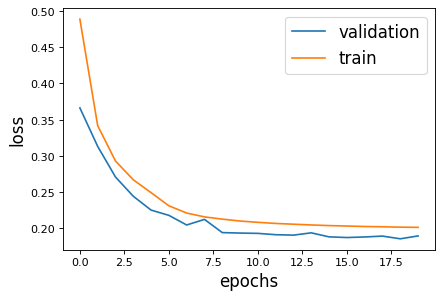

In [176]:
plt.figure(figsize=(6,4), dpi=80)
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.ylabel('loss', fontsize=15)
plt.xlabel('epochs', fontsize=15)
plt.legend(['validation', 'train'], loc='upper right', prop={'size': 15})

In [201]:
preds_auto.shape

(612188, 50, 1)

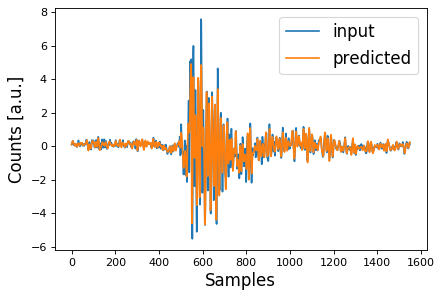

In [262]:
import matplotlib.pyplot as plt
ifeat = 4

n_samp = int( features.shape[0] / (31) )
#features = features.reshape((n_samp, 31 * 50))

plt.figure(figsize=(6,4), dpi=80)
plt.plot(features[ifeat], alpha = 1)
plt.plot(p_auto[ifeat], alpha=1)
plt.ylabel('Counts [a.u.]', fontsize=15)
plt.xlabel('Samples', fontsize=15)
plt.legend(['input', 'predicted'], loc='upper right', prop={'size': 15})

In [0]:
import matplotlib.pyplot as plt
ifeat = 4

yhat = model.predict(features[0:31], verbose=1)
sig = features[0:31]

plt.figure(figsize=(6,4), dpi=80)
plt.plot(features[ifeat], alpha = 1)
plt.plot(preds_auto[ifeat], alpha=1)
plt.ylabel('Counts [a.u.]', fontsize=15)
plt.xlabel('Samples', fontsize=15)
plt.legend(['input', 'predicted'], loc='upper right', prop={'size': 15})

In [0]:
yhat = model.predict(features[0:31], verbose=1)
sig = features[0:31]

31/31 [==============================] - 0s 300us/step


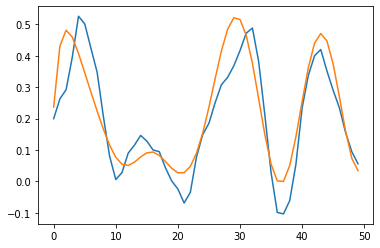

In [0]:
import matplotlib.pyplot as plt
ifeat = 7
#for f, pred in zip(features[ifeat], yhat[ifeat]):
#    print(f, pred)

plt.plot(features[ifeat])
plt.plot(yhat[ifeat])


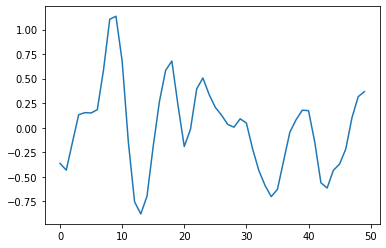

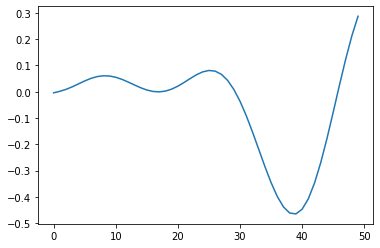

In [0]:
sig = sig.reshape(31 * 50)

In [0]:
yhat = yhat.reshape(31 * 50)

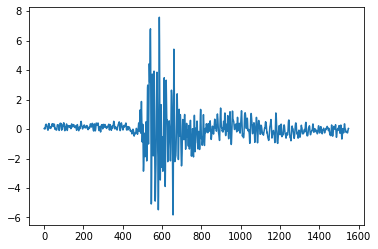

In [0]:
plt.plot(sig)

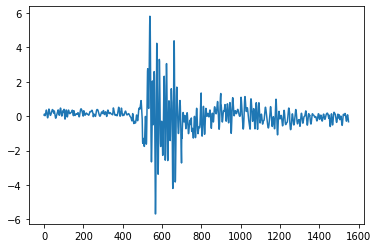

In [0]:
plt.plot(yhat)